In [1]:
# March 2022

# for communication

# twitter https://twitter.com/runaz_there

# Кластеризация

In [2]:
# ! pip install factor_analyzer

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Эта глава посвящена кластеризации и факторному анализу. Кластеризация близко подходит к методу k-ближайщих соседей, а факторный анализ предполагает анализ главных компонент. 

Кластеризация нацелена на разбиение данных по группам. Нечто подобное уже было, когда я для логистической регрессии разбивал данные на группы. Отличие в том, что там использовались квантили только на одномерных данных. В данном же случае будут использованы более продвинутые способы, когда данные разбиваются на группы с позиции многомерных данных. 

Суть кластеризации в следующем. Произвольно назначаю центры. Далее считаю расстояние от ближайших точек к этим центрам на основании квадратичного расстояния. Например, дано четыре центра. До каждого считаю расстояние. Какое меньше, к такому и отношу. Это образует кластеры. В каждом кластере считаю среднее – это новый центр. Пересчитываю расстояния, формирую кластеры. 

Если есть выбросы в данных, то применяется Density-Based Spatial Clustering of Applications with Noise.

Если значения признаков непрерывные, то в качестве меры расстояния между объектами обычно используется расстояние Евклида, а если категориальные, то может использоваться расстояние Хэмминга.

# Загрузка и описание данных

In [4]:
data = pd.read_csv(os.getcwd() + '\\gd_augmentation.csv', 
    dtype = {'decade':'object','quarter':'object', 'tra_co':'object', 'multivolume':'object'}) 

In [5]:
db = data.copy()
db = db.drop(['title', 'language_code'], axis=1)

In [6]:
db.head(3) 

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000


# Подготовка данных

Здесь меня будет интересовать только взаимосвязь средней оценки и количества страниц. Из обработки ограничусь только масштабированием. 

In [7]:
# делаю копию данных
db_scal = db.copy() 

# отбираю количественные признаки
col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'] 

# датафрейм только с количественными признаками
features = db_scal[col] 

# вызываю и обучаю шкалировщик
scaler = QuantileTransformer(n_quantiles=10, random_state=42).fit(features.values) 

# преобразую датафрейм с количественными переменными
features = scaler.transform(features.values) 

# возвращаем данные в исходный датафрейм
db_scal[col] = features 

In [8]:
db_scal.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,0.934551,0.890296,0.939246,0.920679,2000,3,1,1,39,-0.166667,0.166667
1,0.922374,0.894333,0.940642,0.922618,2000,3,1,1,42,0.000000,0.000000
2,0.911720,0.620370,0.769191,0.737192,2000,4,0,1,40,0.000000,0.000000


# Обучение

Вначале я запущу кластеризацию на базовых настройках, произвольно выбрав кластеры. Часто используют 4-5 кластеров. Только после этого начну диагностику модели.

Условия применения метода k средних:

1) кластеры имеют форму круга;

2) признаки должны быть шкалированы;

3) группы сбалансированы, то есть имеют примерно одинаковое количество наблюдений.

<AxesSubplot:xlabel='average_rating', ylabel='num_pages'>

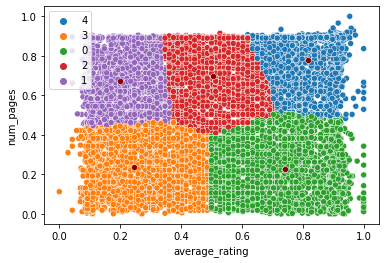

In [9]:
# копирую данные
db_k = db_scal.copy() 

# вызываю модель кластеризации
kmeans = KMeans(n_clusters=5, init='k-means++') 

# тренирую модель
kmeans.fit(db_k[['average_rating', 'num_pages']]) 

# предсказываю классы
y_kmeans = kmeans.predict(db_k[['average_rating', 'num_pages']]) 

# добавляю в наши данные указание на классы для каждого наблюдения
db_k['labels'] = kmeans.labels_.astype(str) 

# строим график с классами
sns.scatterplot(x=db_k['average_rating'], y=db_k['num_pages'], data=db_k, hue=db_k['labels']) 

# извлекаю центроиды из модели
centers = kmeans.cluster_centers_ 

# добавляю на график центроиды
sns.scatterplot(x = centers[: , 0], y = centers[: , 1], color = 'darkred') 

Метод k-средних всегда пытается объединить данные в классы-облака. Кроме того, данные масштабированны.

# Оценка модели

In [10]:
features1 = db_k[['average_rating', 'num_pages']] 

# классы для данных
target = kmeans.labels_

# оценка плотности классов
silhouette_score(features, target)

0.14966215720944162

Плотность должна быть от -1 до 1. Причем данные хорошо разделены, если значение близко к 1.

Есть много других способов оценить модель кластеризации. Эти способы отличаются по наличию или отсутствию истинных, известных классов. Более подробно см. [здесь](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

# Диагностика модели

Главная проблема метода кластеризации - это определение количества классов. Подобрать такое количество можно с помощью графика локтя.

Text(0, 0.5, '$J(C_k)$')

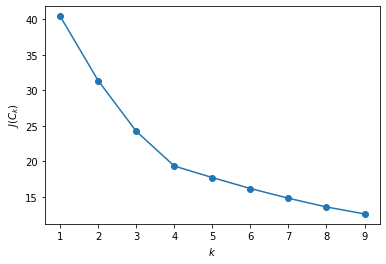

In [11]:
inertia = []
for k in range(1, 10):
    k_means = KMeans(n_clusters=k, random_state=42).fit(db_k[['average_rating', 'num_pages']])
    inertia.append(np.sqrt(k_means.inertia_))

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

На графике линейность появляется после 5. Другими словами, каждая последующая точка после 5 - это просто смещение на одинаковый коэффициент. Для точек выше это не так, например четка видна нелинейность перехода от 4 к 5. Поэтому выше был применен коэффициент 5.

In [12]:
# создаю датафрейм с предсказанными классами
output = pd.DataFrame(data=y_kmeans) 

# смотрю количество наблюдений в каждом классе
output[0].value_counts(ascending=False) 

3    2541
0    2456
4    1999
2    1951
1    1891
Name: 0, dtype: int64

Группы распределены примерно одинаково.

Заметьте, здесь я перехожу к данным до масштабирования. Масштабирование нужно для обучения модели, но понять такие данные затруднительно. Поэтому я возвращаюсь к исходному формату, но с учетом полученных групп.

In [13]:
db_l = db
db_l['clus_membership'] = kmeans.labels_
db_l.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,clus_membership
0,4.57,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667,4
1,4.49,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000,4
2,4.42,352,6333,244,2000,4,0,1,40,0.000000,0.000000,4


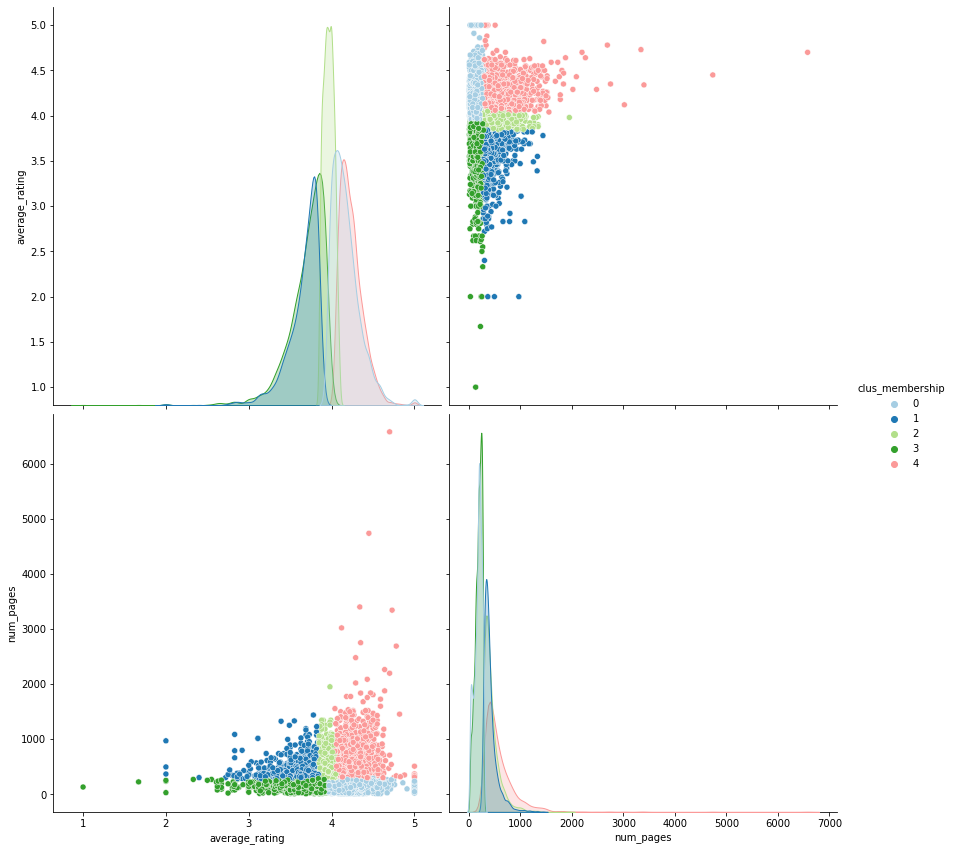

In [14]:
sns.set_palette("Paired")
sns.pairplot(db_l, hue='clus_membership', diag_kind='kde', vars=['average_rating', 'num_pages'], palette='Paired', height=6)

Как еще можно использовать кластеры? Например, можно сгруппировать исходные данные по этим кластерам и поискать зависимости.

In [15]:
db_l.groupby('clus_membership')['ratings_count', 'text_reviews_count'].mean()

C:\Users\runaz\AppData\Local\Temp/ipykernel_76840/3442213966.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  db_l.groupby('clus_membership')['ratings_count', 'text_reviews_count'].mean()


,ratings_count,text_reviews_count
clus_membership,,
0,16061.943811,475.596906
1,17191.654151,545.819143
2,20488.282932,637.131727
3,11003.386856,379.867375
4,29497.025013,793.260130


# DBSCAN

Каждой точке данных присваивается специальная метка. Вот как это описано в учебнике Машинное обучение:

1. Точка считается ядерной, если, по крайней мере, указанное количество (MinPts) соседних точек попадают внутри заданного радиуса e.

2. Граничная точка - это точка, имеющая число соседей меньше MinPts в пределах e, но лежащая внутри радиуса e ядерной точки.

3. Все остальные точки, которые не являются ядерными или граничными, трактуются как шумовые.

Далее алгоритм такой:

1. Сформировать отдельный кластер для каждой ядерной точки или связной группы ядерных точек. (Ядерные точки считаются связными, если расположены не дальше чем e).
2. Назначить каждую граничную точку кластеру, к которому принадлежит соответствующая ей ядерная точка.


Хорошое описание метода можно найти [здесь](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/).

In [16]:
db_scan = db.copy()

# отбираю количественные переменные
col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'] 

# датафрейм только с количественными переменными
features = db_scan[col] 

# вызываю и обучаю шкалировщик
scaler = StandardScaler().fit(features.values) 

# преобразую датафрейм с количественными признаками
features = scaler.transform(features.values) 

# возвращаю данные в исходный датафрейм
db_scan[col] = features 

db_scan.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,clus_membership
0,2.125587,1.290424,18.244584,10.402361,2000,3,1,1,39,-0.166667,0.166667,4
1,1.854744,2.204297,18.749384,11.029475,2000,3,1,1,42,0.000000,0.000000,4
2,1.617755,0.032802,-0.105523,-0.118911,2000,4,0,1,40,0.000000,0.000000,4


In [17]:
# вызываю модель
clus_dbscan = DBSCAN(eps=2, min_samples=10) 

# тренируюю модель
scan_model = clus_dbscan.fit(db_scan[['average_rating', 'num_pages']]) 

In [18]:
scan_model.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

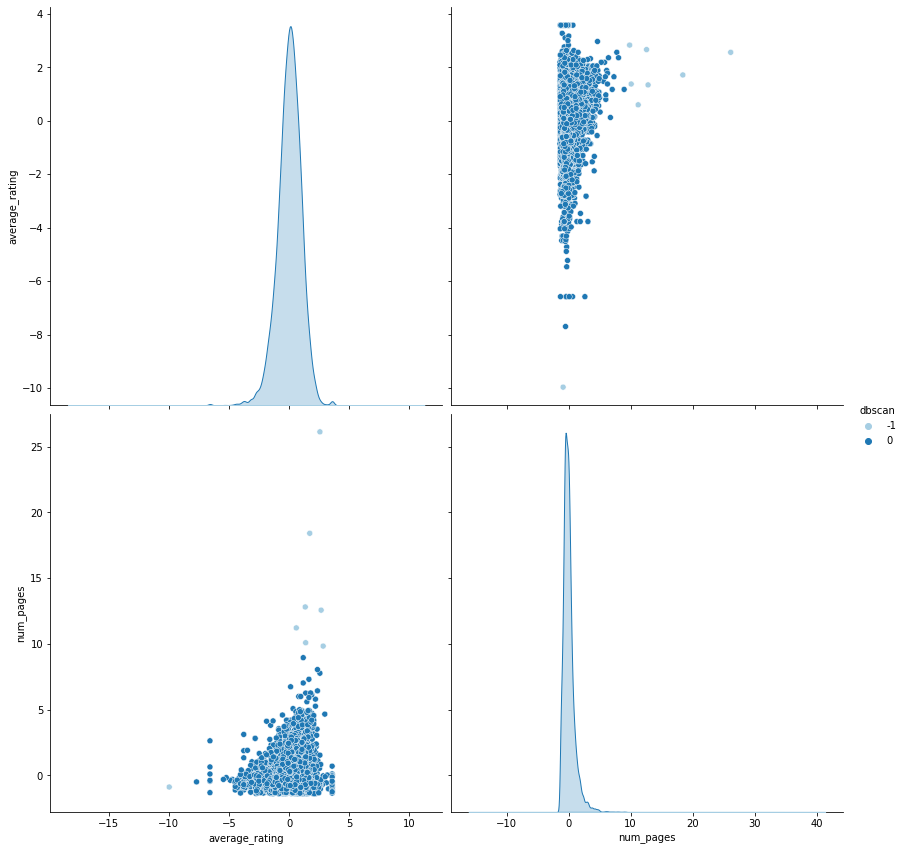

In [19]:
db_scan['dbscan'] = scan_model.labels_
sns.set_palette("Paired")
sns.pairplot(db_scan, hue='dbscan', diag_kind='kde', vars=['average_rating', 'num_pages'], palette='Paired', height=6)

Для этого алгоритма самое важное - правильно определить эпсилон, то есть минимальное количество точек, необходимых для формирования области. 

In [20]:
# получаю значение эпсилон
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(db_scan[['average_rating', 'num_pages']])
distances, indices = nbrs.kneighbors(db_scan[['average_rating', 'num_pages']])
distances

array([[0.        , 0.07513325],
       [0.        , 0.02515245],
       [0.        , 0.00419207],
       ...,
       [0.        , 0.00419207],
       [0.        , 0.00838415],
       [0.        , 0.        ]])

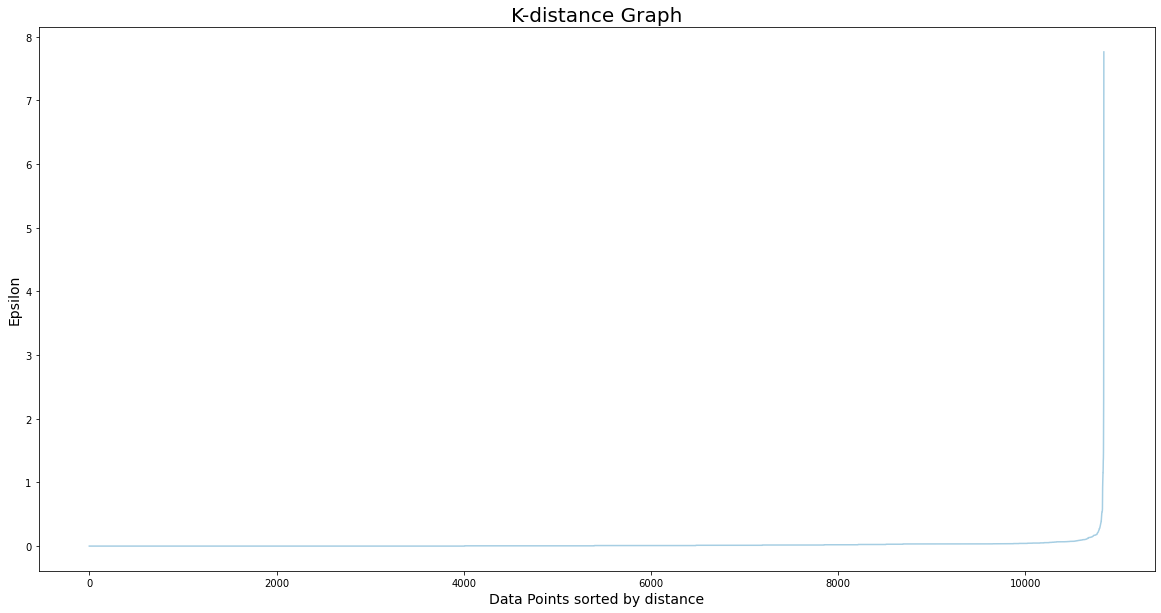

In [21]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Этот график позволяет определить эпсилон для DBSCAN.

# К-ближайщих соседей

Применение k-средних предполагает, что решается задача кластеризации. В свою очередь k-ближайших соседей решает задачу классификации.

См. также гл. 13 учебника Основы обучения.

## Нахождение ближайщих соседей наблюдения

In [22]:
# копирую исходные данные
db_n = db_scal.copy() 

# тренирую модель
nearest_neighbors = NearestNeighbors(n_neighbors=2).fit(db_n) 

# создаю новый признак
new_observation = [0.965, 0.745, 0.645, 0.812, 2000, 4, 1, 1, 42, 0.7, 0.8] 

# получаю класс для нового признака
distances, indices = nearest_neighbors.kneighbors([new_observation]) 
indices

array([[6970, 5794]], dtype=int64)

Здесь индекс двух наблюдений, которые находятся ближе всего к заданному.

## K-ближайших соседей

In [23]:
db_nk = db.copy() 

# группы, на которые разобью среднюю оценку
bins = [0, 4, 5] 

# название этих групп
groups_names = ['0', '1'] 

# провожу разбиение на группы
db_nk['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=True).astype('int64') 

# удаляю количественную переменную, на основании которой построил бинарную
db_nk = db_nk.drop(['average_rating', 'clus_membership'], axis=1) 
db_nk

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity,rating_groups
0,652,2095690,27591,2000,3,1,1,39,-0.166667,0.166667,1
1,870,2153167,29221,2000,3,1,1,42,0.000000,0.000000,1
2,352,6333,244,2000,4,0,1,40,0.000000,0.000000,1
3,435,2339585,36325,2000,2,1,1,41,0.000000,0.000000,1
4,2690,41428,164,2000,3,1,1,34,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
10833,512,156,20,2000,4,1,1,48,0.000000,0.000000,1
10834,635,783,56,1980,4,0,0,27,0.700000,0.800000,1
10835,415,820,95,1990,3,0,1,14,0.000000,0.000000,0
10836,434,769,139,2000,1,0,0,11,-0.400000,0.600000,0


In [24]:
col = ['num_pages', 'ratings_count', 'text_reviews_count']
features = db_nk[col]
scaler = QuantileTransformer(n_quantiles=10, random_state=42).fit(features.values)
features = scaler.transform(features.values)
db_nk[col] = features

In [25]:
# независимые переменные
X = db_nk.drop('rating_groups', axis=1) 

# зависимая переменная
y = db_nk['rating_groups'] 

In [26]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X, y) 
X.head(3)

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,0.890296,0.939246,0.920679,2000,3,1,1,39,-0.166667,0.166667
1,0.894333,0.940642,0.922618,2000,3,1,1,42,0.000000,0.000000
2,0.620370,0.769191,0.737192,2000,4,0,1,40,0.000000,0.000000


In [27]:
# новое наблюдение
new_observation1 = [[0.745, 0.645, 0.812, 2000, 4, 1, 1, 42, 0.7, 0.8]] 
knn.predict(new_observation1)

array([1], dtype=int64)

Модель относит новое наблюдение к первому классу, то есть книга получит оценку от 4.

Можно оценить модель классификации теми же способами, которые применяли для логистической регрессии.

# Анализ главных компонент

Text(0.5, 0.92, 'simple 3D scatter plot')

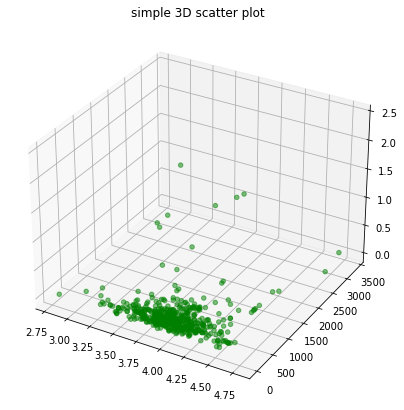

In [28]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(db.loc[1:500, 'average_rating'], db.loc[1:500, 'num_pages'], db.loc[1:500, 'ratings_count'], color = "green", alpha=0.5)
plt.title("simple 3D scatter plot")

In [29]:
# указываем количество сохраненных компонент
pca = PCA(n_components=2) 
X2D = pca.fit_transform(db[['average_rating', 'num_pages', 'ratings_count']])
X2D

array([[ 2.07734213e+06,  1.76915926e+02],
       [ 2.13481915e+06,  3.91293844e+02],
       [-1.20148820e+04,  8.58203378e+00],
       ...,
       [-1.75278780e+04,  7.19293492e+01],
       [-1.75788768e+04,  9.09325112e+01],
       [-1.82348871e+04, -7.10261045e+01]])

In [30]:
# дисперсия, которую объясняют наши компоненты
pca.explained_variance_ratio_  

array([9.99995615e-01, 4.38529562e-06])

# Факторный анализ

In [31]:
# количественные переменные
db_f = db[['average_rating', 'num_pages', 'ratings_count']] 

Сначала надо провести тест на возможность применения факторного анализа. 

Два основных теста:

1) Bartlett’s Test

2) Kaiser-Meyer-Olkin Test

In [32]:
chi_square_value,p_value=calculate_bartlett_sphericity(db_f)
chi_square_value, p_value

(361.79861008986325, 4.157181502859784e-78)

Зp-value (второй столбец) показывает статистическую значимость теста, а значит можно продолжить факторный анализ.

In [33]:
kmo_all,kmo_model=calculate_kmo(db_f)
kmo_model

0.5082998418407512

Здесь значение должно быть от 0,6 и выше. что не выполняется. Для примера продолжу.

In [34]:
# вращение осей
fa = FactorAnalyzer(rotation='varimax')
fa.fit(db_f, 3)
ev, v = fa.get_eigenvalues()
ev

array([1.18793058, 0.98676895, 0.82530047])

In [35]:
print(fa.loadings_)

[[0.38840699 0.17333818 0.        ]
 [0.40989283 0.08716909 0.        ]
 [0.04309694 0.14241087 0.        ]]


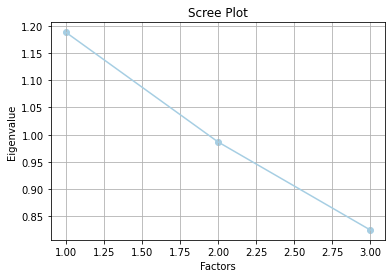

In [36]:
plt.scatter(range(1,db_f.shape[1]+1),ev)
plt.plot(range(1,db_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Для выбора количества факторов необходимо взять только те факторы, для которых собственные значения по оси y больше 1. Здесь это только один фактор, но и второй приближается к этому значению. Возьму также и его. 

In [37]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(db_f)
ev, v = fa.get_eigenvalues()
ev

array([1.18793058, 0.98676895, 0.82530047])

In [38]:
fa.get_factor_variance()

(array([0.32072947, 0.05792543]),
 array([0.10690982, 0.01930848]),
 array([0.10690982, 0.1262183 ]))

In [39]:
print(pd.DataFrame(fa.loadings_,index=db_f.columns))

                       0         1
average_rating  0.388407  0.173338
num_pages       0.409893  0.087169
ratings_count   0.043097  0.142411


Чем ближе к 1, тем больше фактор может объяснить признак. Здесь таких значений нет.

# Приложение 1

## Рекомендуемая литература

1) Сара Бослаф Статистика для всех
2) П. Брюс Практическая статистика для специалистов Data Science
3) С. Рашка, В. Мирджалили Python и машинное обучение
4) "Изучаем Pandas" Майкл Хейдт, Артем Груздев (обязательно второе издание).
5)  Тревор Хасти, Роберт Тибширани, Джером Фридман Основы статистического обучения (по тексту - учебник Основы обучения)
6) С. Рашка, В. Мирджалили Python и машинное обучение (по тексту - учебник Машинное обучение)

## Полезные ссылки

1) руководство по применению регулярных выражений [здесь](https://developers.google.com/edu/python/regular-expressions);
2) еще одно руководство по регулярным выражениям от проекта [Dataquest](https://www.dataquest.io/blog/regular-expressions-data-scientists/);
3) и еще немного про регулярные выражения от [Towards Data Science](https://towardsdatascience.com/easiest-way-to-remember-regular-expressions-regex-178ba518bebd);
3) математическая энциклопедия от проекта [Wolfram](https://mathworld.wolfram.com/).

**Ссылки на мои ресурсы:**

1) Twitter https://twitter.com/runaz_there
2) GitHub https://github.com/Ruslan-Nazarov
3) AI for everyone (Medium) https://medium.com/ai-for-everyone
4) LinkedIn https://www.linkedin.com/in/ruslan-nazarov-223003198/
5) email runaz2007@gmail.com OR runaz@protonmail.com